In [1]:
%load_ext autoreload
%autoreload 2

from ml_collections import config_dict
import jax.random as random

from src.utils.training import setup_model, get_dataset_splits, train_loop
import src.utils.input as i

from absl import logging
logging.set_verbosity(logging.INFO)

In [2]:
rng = random.PRNGKey(0)
data_rng, model_rng = random.split(rng)

In [3]:
def get_config(low_angle, high_angle) -> config_dict.ConfigDict:
    config = config_dict.ConfigDict()

    # Dataset config
    config.dataset = 'MNIST'
    # config.data_dir = '~/data'
    config.shuffle_buffer_size = 50_000
    config.repeat_after_batch = True  # NOTE: ordering of PP and repeat is important!
    config.train_split = 'train[10000:]'
    config.pp_train = f'value_range(-1, 1)|random_rotate({low_angle}, {high_angle}, fill_value=-1)|keep(["image"])'
    config.val_split = 'train[:10000]'
    config.pp_eval = f'value_range(-1, 1)|random_rotate({low_angle}, {high_angle}, fill_value=-1)|keep(["image"])'

    # Model config
    config.model_name = 'LIVAE'
    config.model = config_dict.ConfigDict()
    config.model.latent_dim = 20
    ## q(Z|X) config
    config.model.Z_given_X = config_dict.ConfigDict()
    config.model.Z_given_X.hidden_dims = [64, 128, 256]
    ## p(X̂|Z) config
    config.model.Xhat_given_Z = config_dict.ConfigDict()
    config.model.Xhat_given_Z.hidden_dims = [256, 128, 64]
    # p(η|Z) config
    config.model.Eta_given_Z = config_dict.ConfigDict()
    config.model.Eta_given_Z.base = config_dict.ConfigDict()
    config.model.Eta_given_Z.base.hidden_dims = [64, 32]
    config.model.Eta_given_Z.bijector = config_dict.ConfigDict()
    config.model.Eta_given_Z.bijector.num_layers = 2
    config.model.Eta_given_Z.bijector.num_bins = 4
    config.model.Eta_given_Z.bijector.hidden_dims = [64, 32]
    # p(η|X) config
    config.model.Eta_given_X = config_dict.ConfigDict()
    config.model.Eta_given_X.base = config_dict.ConfigDict()
    config.model.Eta_given_X.base.hidden_dims = [64, 32]
    config.model.Eta_given_X.bijector = config.model.Eta_given_Z.bijector
    # TODO: raise error if bijector config is not the same for both

    # Training config
    config.total_steps = 15000
    config.batch_size = 256

    ## Optimizer config
    config.optim_name = 'adamw'
    config.learning_rate = 1e-4
    config.optim = config_dict.ConfigDict()
    config.optim.weight_decay = 1e-4

    ## β config
    config.β = 10
    config.β_schedule_name = 'cosine_decay_schedule'
    config.β_schedule = config_dict.ConfigDict()
    β_end_value = 1
    config.β_schedule.alpha = β_end_value / config.β
    config.β_schedule.decay_steps = config.total_steps

    ## LR config
    config.lr_schedule_name = 'warmup_cosine_decay_schedule'
    config.lr_schedule = config_dict.ConfigDict()
    config.lr_schedule.peak_value = 10 * config.learning_rate
    config.lr_schedule.end_value = config.learning_rate
    config.lr_schedule.decay_steps = config.total_steps
    config.lr_schedule.warmup_steps = 1000

    return config

config = get_config(-45, 45)

In [4]:
train_ds, val_ds, _ = get_dataset_splits(config, data_rng, 256, 256)

INFO:absl:Initializing train dataset...
INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.splits from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.supervised_keys from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.module_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-0.7853981633974483, θ_max=0.7853981633974483, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op Keep(keys=['image']):
{'image': 'float32[28, 28, 1]'}
INFO:absl:Features after preprocessing: {'image': 'float32[28, 28, 1]'}
INFO:absl:Initializing val dataset...
INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.splits from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.supervised_keys from disk and from code do not match. Keeping the one fro

In [5]:
ds = i.start_input_pipeline(train_ds, 1)
next(ds)['image'].shape

(1, 256, 28, 28, 1)

In [6]:
model, state = setup_model(config, model_rng, train_ds)

INFO:absl:Initializing model...
INFO:absl:config.model_name = LIVAE
INFO:absl:config.model = Eta_given_X:
  base:
    hidden_dims:
    - 64
    - 32
  bijector: &id001
    hidden_dims:
    - 64
    - 32
    num_bins: 4
    num_layers: 2
Eta_given_Z:
  base:
    hidden_dims:
    - 64
    - 32
  bijector: *id001
Xhat_given_Z:
  hidden_dims:
  - 256
  - 128
  - 64
Z_given_X:
  hidden_dims:
  - 64
  - 128
  - 256
latent_dim: 20

INFO:absl:input_size = (28, 28, 1)
INFO:absl:Initializing model...
INFO:absl:
+---------------------------------------------+------------------+-----------+-----------+----------+
| Name                                        | Shape            | Size      | Mean      | Std      |
+---------------------------------------------+------------------+-----------+-----------+----------+
| params/p_Xhat_given_Z/hidden0/bias          | (256,)           | 256       | 0.0       | 0.0      |
| params/p_Xhat_given_Z/hidden0/kernel        | (3, 3, 256, 256) | 589,824   | 2.89e-

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
INFO:absl:Setting up datasets...
INFO:absl:Global batch size 256 on 1 hosts results in 256 local batch size. With 1 devices per host (1 devices total), that's a 256 per-device batch size.
INFO:absl:Initializing train dataset...
INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.splits from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.supervised_keys from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.module_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:]', index=0, count=1, drop_remainder=False), from /homes/jua

  0%|          | 0/30000 [00:00<?, ?it/s]

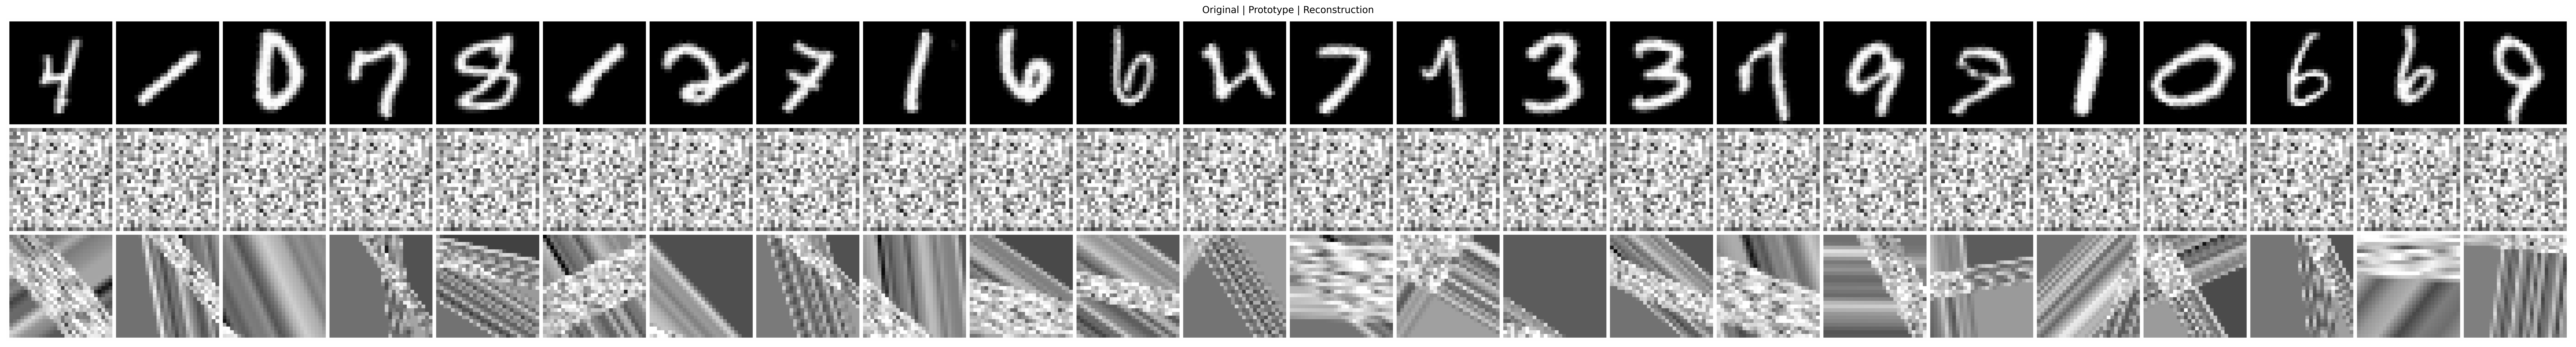

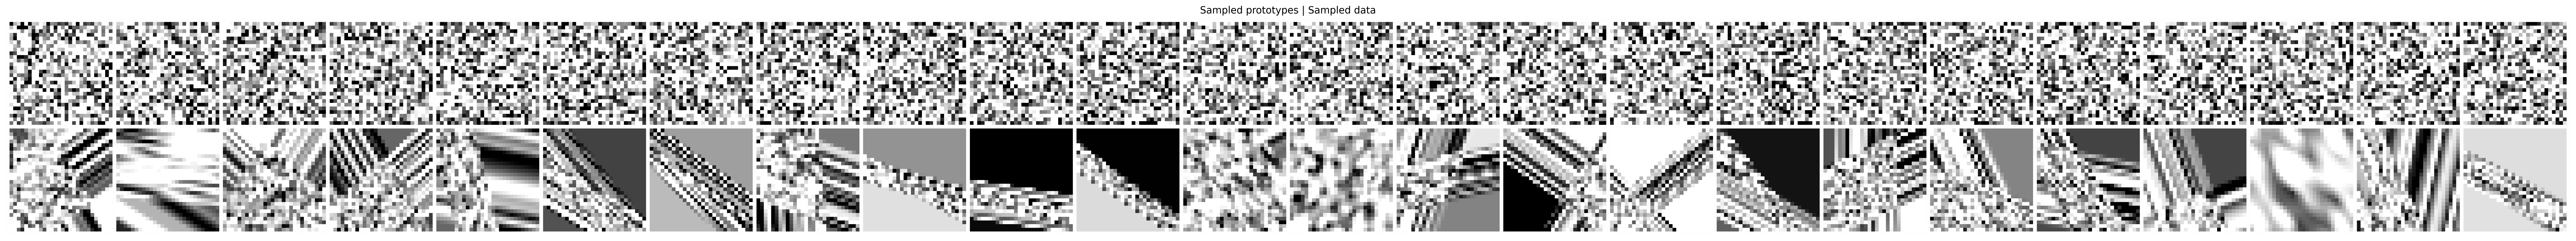

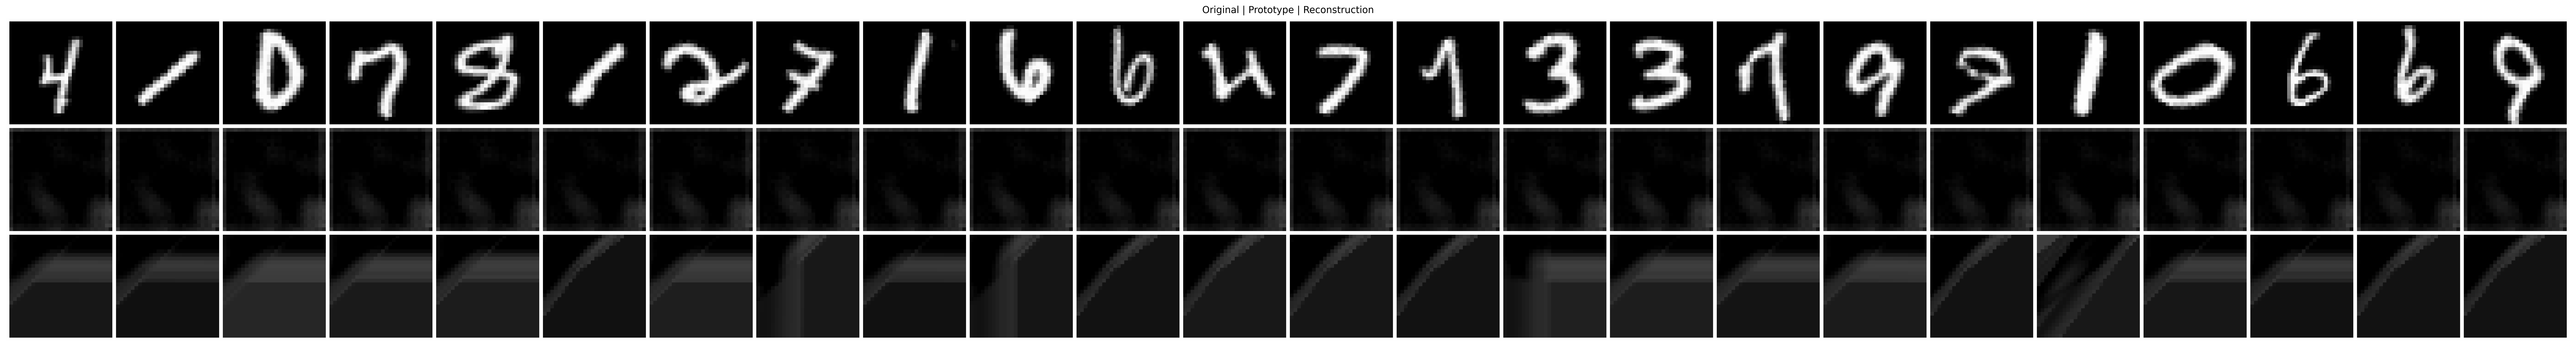

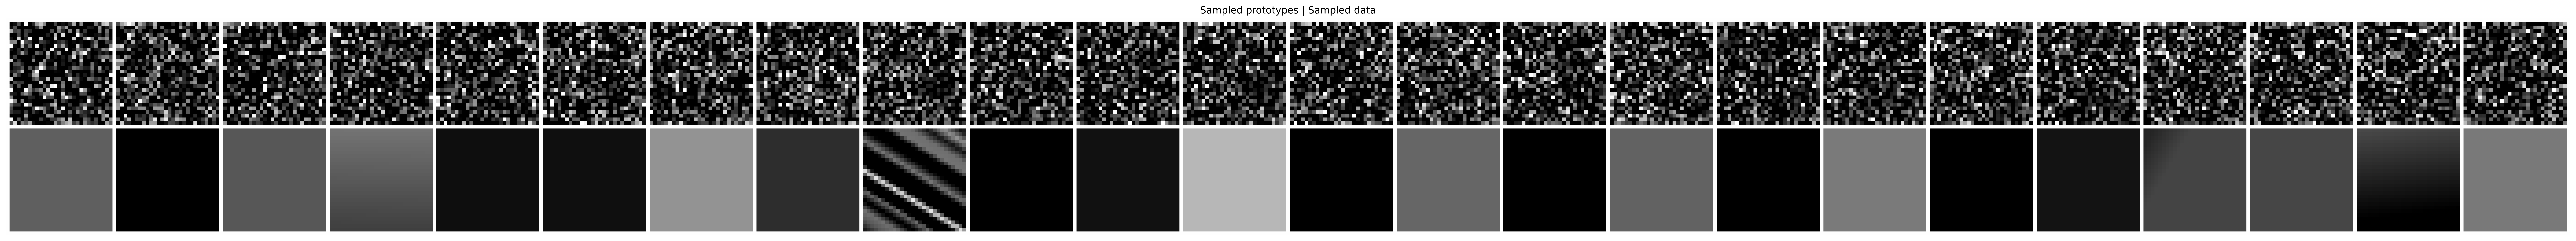

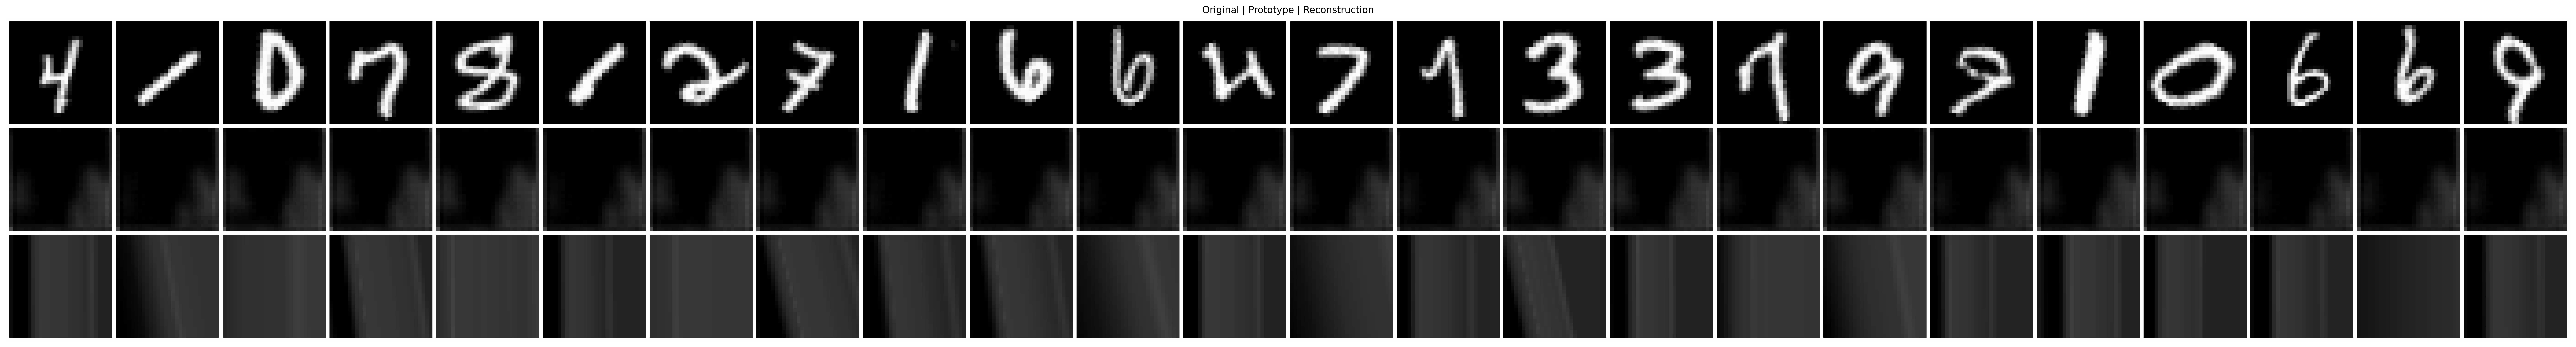

KeyboardInterrupt: 

In [7]:
train_loop(config, model, state, train_ds, val_ds, wandb_kwargs={'mode': 'disabled'});